In [58]:
from utils import *
from models import *
from loss import *
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime
from torch.nn.functional import leaky_relu, sigmoid

In [ ]:
train_path = './next_day_fires/next_day_wildfire_spread_train*'
val_path = './next_day_fires/next_day_wildfire_spread_eval*'
test_path = './next_day_fires/next_day_wildfire_spread_test*'
features = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']

# Load Data

## Training Data

In [60]:
train_dataset = get_dataset(
      train_path,
      data_size=64,
      sample_size=32,
      batch_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=False)

train_inputs, train_labels = next(iter(train_dataset))

print(train_inputs.shape)
print(train_labels.shape)

torch.Size([64, 12, 64, 64])
torch.Size([64, 1, 64, 64])


In [61]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

n_rows = 5
n_features = train_inputs.shape[3] 
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

In [62]:
# fig = plt.figure(figsize=(20,8))

# for i in range(n_rows):
#   for j in range(n_features + 1):
#     plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
#     if i == 0:
#       plt.title(titles[j], fontsize=15)
#     if j < n_features - 1:
#       plt.imshow(train_inputs[i, j, :, :], cmap='viridis')
#     if j == n_features - 1:
#       plt.imshow(train_inputs[i, -1, :, :], cmap=CMAP, norm=NORM)
#     if j == n_features:
#       plt.imshow(train_labels[i, 0, :, :], cmap=CMAP, norm=NORM) 
#     plt.axis('off')
# plt.tight_layout()

## Vlidation Data

In [63]:
val_dataset = get_dataset(
      val_path,
      data_size=64,
      sample_size=32,
      batch_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=False)

val_inputs, val_labels = next(iter(val_dataset))

print(val_inputs.shape)
print(val_labels.shape)

torch.Size([64, 12, 64, 64])
torch.Size([64, 1, 64, 64])


## Test Data

In [64]:
test_dataset = get_dataset(
      test_path,
      data_size=64,
      sample_size=32,
      batch_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=False,
      center_crop=False)

test_inputs, test_labels = next(iter(val_dataset))

print(test_inputs.shape)
print(test_labels.shape)

torch.Size([64, 12, 64, 64])
torch.Size([64, 1, 64, 64])


In [65]:
# Build DataLoader
train_loader = DataLoader(train_dataset, batch_size=None, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=None, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=None, num_workers=0, pin_memory=True)

# Model Initialization

In [66]:
class UNet(nn.Module):
    def __init__(self, kernel_size, stride, padding):
        super().__init__()

        # First we need to make the Encoder
        # There are 5 Encoder modules, each consisting of two convolution encoder layers to 
        # increase the number of channels and a maxpooling layer to downsample
        self.e11 = nn.Conv2d(12, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.eb11 = nn.BatchNorm2d(32)
        self.e12 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.eb12 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.eb21 = nn.BatchNorm2d(64)
        self.e22 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.eb22 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.eb31 = nn.BatchNorm2d(128)
        self.e32 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.eb32 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e42 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        # self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # self.e51 = nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding)
        # self.e52 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bb1 =nn.BatchNorm2d(256)
        self.bb2 =nn.BatchNorm2d(256)

        # self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # self.d11 = nn.Conv2d(512, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        # self.d12 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.db21 = nn.BatchNorm2d(128)
        self.d21 = nn.Conv2d(256, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.db22 = nn.BatchNorm2d(128)
        self.d22 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.db23 = nn.BatchNorm2d(128)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.db31 = nn.BatchNorm2d(64)
        self.d31 = nn.Conv2d(128, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.db32 = nn.BatchNorm2d(64)
        self.d32 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.eb33 = nn.BatchNorm2d(64)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.db41 = nn.BatchNorm2d(32)
        self.d41 = nn.Conv2d(64, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.db42 = nn.BatchNorm2d(32)
        self.d42 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.db43 = nn.BatchNorm2d(32)


        # Finally, we use a final output layer to create a single channel prediction
        self.output = nn.Conv2d(32, 1, kernel_size=1)


    def forward(self, x):
        # Encoder
        e11 = leaky_relu(self.eb11(self.e11(x)))
        e12 = leaky_relu(self.eb12(self.e12(e11)))
        maxpool1 = self.maxpool1(e12)

        e21 = leaky_relu(self.eb21(self.e21(maxpool1)))
        e22 = leaky_relu(self.eb22(self.e22(e21)))
        maxpool2 = self.maxpool2(e22)

        e31 = leaky_relu(self.eb31(self.e31(maxpool2)))
        e32 = leaky_relu(self.eb32(self.e32(e31)))
        maxpool3 = self.maxpool3(e32)

        e41 = leaky_relu(self.bb1(self.e41(maxpool3)))
        e42 = leaky_relu(self.bb2(self.e42(e41)))

        # Decoder
        upconv2 = leaky_relu(self.upconv2(e42))
        upconv2 = torch.cat([upconv2, e32], dim=1)
        d21 = leaky_relu(self.db21(self.d21(upconv2)))
        d22 = leaky_relu(self.db22(self.d22(d21)))
        d22 = self.db23(d22)

        upconv3 = leaky_relu(self.upconv3(d22))
        upconv3 = torch.cat([upconv3, e22], dim=1)
        d31 = leaky_relu(self.db31(self.d31(upconv3)))
        d32 = leaky_relu(self.db32(self.d32(d31)))
        d32 = self.eb33(d32)

        upconv4 = leaky_relu(self.upconv4(d32))
        upconv4 = torch.cat([upconv4, e12], dim=1)
        d41 = leaky_relu(self.db41(self.d41(upconv4)))
        d42 = leaky_relu(self.db42(self.d42(d41)))
        d42 = self.db43(d42)

        # Output layer
        out = self.output(d42)
        out = sigmoid(out)

        return out

### Hyperparameters

In [67]:
# parameter setup
folder_path = './UNET_models'

kernel_size = 3
stride = 1
padding = 1

num_epochs = 100
patience = 25

pos_weight = 20
bce_weight = 0.3 # Coefficient for Binary Cross Entropy loss in loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loss Function

In [68]:
# Loss function setup
# Create a class for Dice Loss
class DiceLoss(nn.Module):
    # Initializing the loss function will require a smoothing parameter to prevent division by zero 
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    # The loss function is defined in a forward pass as 2*(intersection)/(pred + true)
    def forward(self, pred, true):
        pred = pred.view(-1)
        true = true.view(-1)
        intersection = (pred*true).sum()
        dice = (2*intersection + self.smooth) / (pred.sum() + true.sum() + self.smooth)
        return 1 - dice

# Create a class for BCE Loss
class BCEDiceLoss(nn.Module):
    # Initializing the loss function will require a BCE weight parameter to determine the weigth of each loss 
    def __init__(self, bce_weight=0.5, pos_weight=30):
        super().__init__()
        # Declare both loss functions
        pos_weight = torch.tensor([pos_weight]).to(device)
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    # The loss function is defined by taking the weighted sum of BCE Loss and Dice Loss
    def forward(self, pred, true):
        bce_loss = self.bce(pred, true)
        dice_loss = self.dice(pred, true)
        return bce_weight * bce_loss + (1-bce_weight) * dice_loss

### Model Initialization

In [69]:
# Create an instance of UNet
model = UNet(kernel_size, stride, padding)
model.to(device)

UNet(
  (e11): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (eb11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (eb12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (eb21): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (e22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (eb22): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (eb31): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

# Model Training

In [70]:
# Train UNET
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_model_filename = None

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss(bce_weight=0.5, pos_weight=pos_weight)

# Train over the entire dataset every epoch
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # Train in batches to improve efficiency
    for batch in train_loader:
        optimizer.zero_grad(set_to_none=True)
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        # Make predictions on the training images
        pred_mask = model(images)

        # Calculate the loss and take an optimization step based on the predictions
        loss = 0
        loss += criterion(pred_mask, true_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Average the loss over all batches
    avg_loss = total_loss / len(train_loader)

    # Now, validate the model
    model.eval()
    val_loss = 0

    # Gradients are not used as validation is used to find the best model without further optimization
    with torch.no_grad():
        # Validate in batches
        for batch in val_loader:
            images, true_mask = batch
            images = images.to(device)
            true_mask = true_mask.to(device)
            
            # Make predictions on the validation images
            pred_mask = model(images)

            # Calculate the loss
            loss = 0
            loss += criterion(pred_mask, true_mask)
            val_loss += loss.item()
    
    # Average the validation loss over all batches
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

    # Best model saving & early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() 
        best_model_filename = f"{folder_path}/best_model_{str(best_val_loss)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

        

Epoch 1/100 - Train Loss: 0.9591 - Validation Loss: 0.9383
Validation loss improved. Best model updated.
Epoch 2/100 - Train Loss: 0.9262 - Validation Loss: 0.9204
Validation loss improved. Best model updated.
Epoch 3/100 - Train Loss: 0.9109 - Validation Loss: 0.9127
Validation loss improved. Best model updated.
Epoch 4/100 - Train Loss: 0.8951 - Validation Loss: 0.8955
Validation loss improved. Best model updated.
Epoch 5/100 - Train Loss: 0.8795 - Validation Loss: 0.8846
Validation loss improved. Best model updated.
Epoch 6/100 - Train Loss: 0.8634 - Validation Loss: 0.8725
Validation loss improved. Best model updated.
Epoch 7/100 - Train Loss: 0.8438 - Validation Loss: 0.8619
Validation loss improved. Best model updated.
Epoch 8/100 - Train Loss: 0.8265 - Validation Loss: 0.8459
Validation loss improved. Best model updated.
Epoch 9/100 - Train Loss: 0.8017 - Validation Loss: 0.8487
No improvement for 1 epoch(s).
Epoch 10/100 - Train Loss: 0.7862 - Validation Loss: 0.8334
Validation

In [71]:
# save the best model
# PREVIOUS: ./UNET_models/best_model_0.7842318926538739_20250428_175259.pth
os.makedirs('./UNET_models', exist_ok=True)
if best_model_state is not None:
    torch.save(best_model_state, best_model_filename)
    print(f"Best model saved to {best_model_filename}")

Best model saved to ./UNET_models/best_model_0.7827220218522208_20250428_183431.pth


# Model Testing

In [72]:
# test UNET
model.load_state_dict(torch.load(best_model_filename, map_location=device))
model.eval()

# Create arrays to store all predictions and all ground truth masks
pred_mask_all, true_mask_all = [], []

with torch.no_grad():
    for batch in test_loader:
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        # Make test predictions
        pred_mask = model(images)

        pred_mask_all.append(pred_mask.cpu().numpy())
        true_mask_all.append(true_mask.cpu().numpy())

    # Concatenate all batches into a single array for performance                        
    preds = np.concatenate(pred_mask_all, axis=0)   
    trues = np.concatenate(true_mask_all, axis=0)        

    # Squeeze from 4 dimensions into 3 since we use only one channel
    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds.squeeze(1)
        trues = trues.squeeze(1)
    
    trues_copy = np.copy(trues)
    preds_copy = np.copy(preds)

    # Binarize predictions
    preds  = (preds > 0.5).astype(np.uint8)
    trues  = trues.astype(np.uint8)
    preds = preds.flatten()
    trues = trues.flatten()

    # Calculate TP, FP, FN for evaluation metrics
    tp = np.logical_and(preds==1, trues==1).sum()
    fp = np.logical_and(preds==1, trues==0).sum()
    fn = np.logical_and(preds==0, trues==1).sum()

    # Calculate evaluation metrics
    smooth = 1e-6
    dice = (2*tp + smooth) / (2*tp + fp + fn + smooth)
    iou  = (tp + smooth)   / (tp + fp + fn + smooth)
    recall = tp / (tp + fn + smooth)

                             
    # Dice coefficient
    # IoU (Jaccard Index)
    # Recall - We care a lot about false negatives
    metrics = {
        'Dice Coefficient': dice,
        'IoU': iou,
        'Recall': recall
        }
    
    print("\n **Test Results:**")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

C:\Users\joebe\AppData\Local\Temp\ipykernel_20628\4058782732.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_filename, map_lo


 **Test Results:**
Dice Coefficient: 0.2358
IoU: 0.1337
Recall: 0.1717


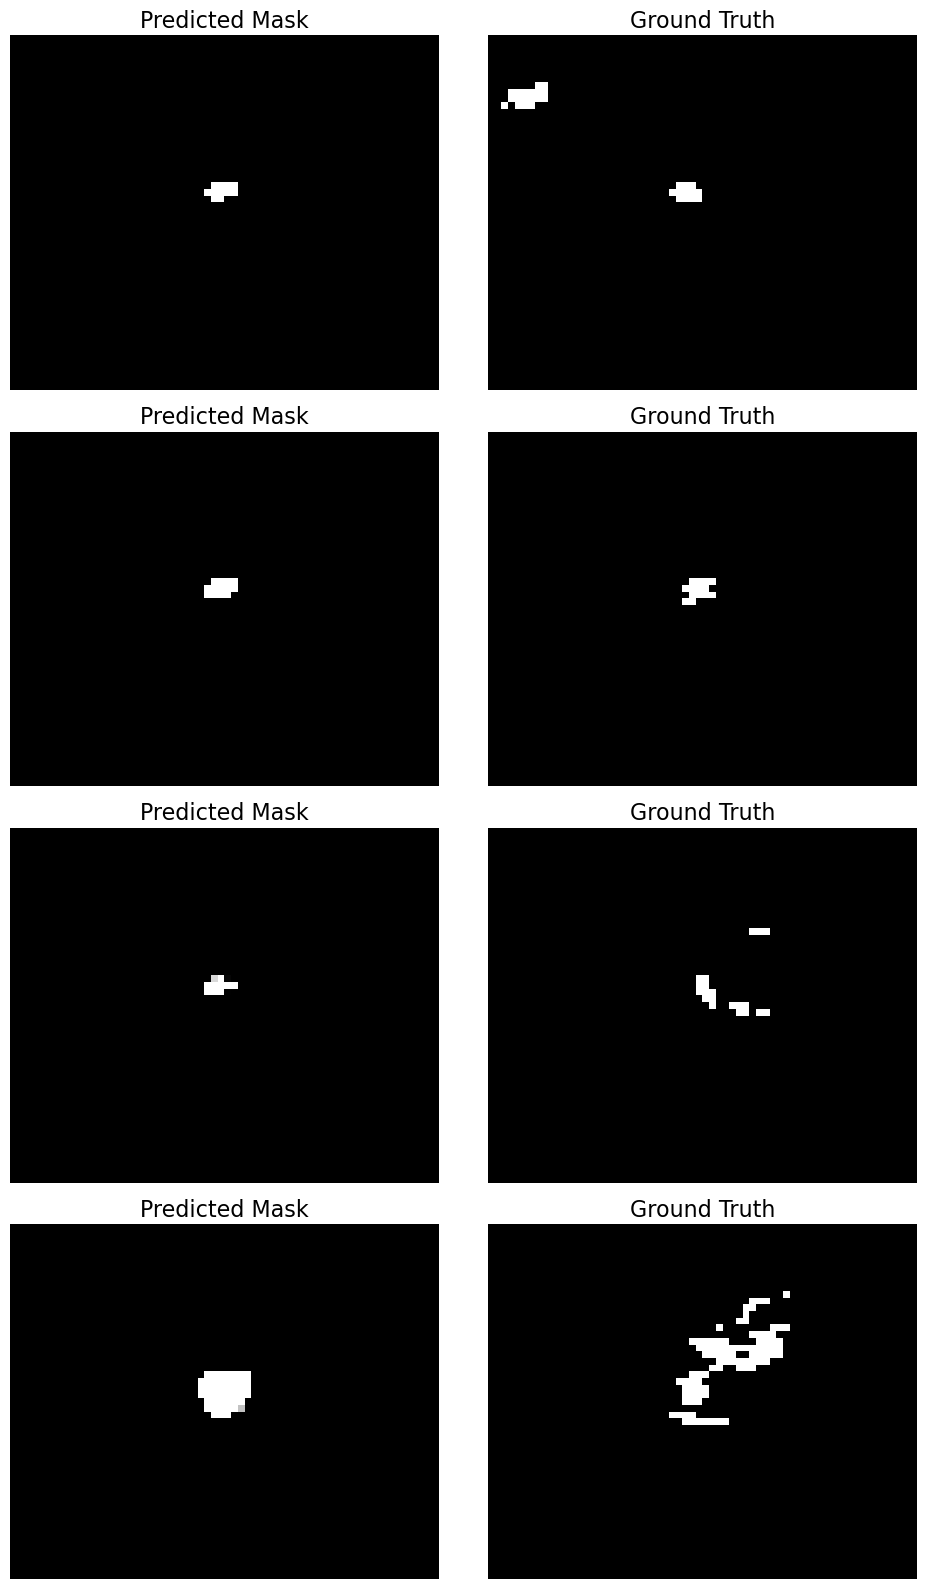

In [100]:
fig, axes = plt.subplots(4, 2, figsize=(10, 4 * 4))

for i in range(4):
    axes[i, 0].imshow(preds_copy[i][4:61][4:61], cmap='gray')  # or cmap='gray' if you want grayscale
    axes[i, 0].set_title("Predicted Mask", fontsize=16)
    axes[i, 0].axis('off')
    axes[i, 1].imshow(trues_copy[i][4:61][4:61], cmap='gray')  # or cmap='gray' if you want grayscale
    axes[i, 1].set_title("Ground Truth", fontsize=16)
    axes[i, 1].axis('off')

axes[1, 0].imshow(preds_copy[4][4:61][4:61], cmap='gray')  # or cmap='gray' if you want grayscale
axes[1, 0].set_title("Predicted Mask", fontsize=16)
axes[1, 0].axis('off')
axes[1, 1].imshow(trues_copy[4][4:61][4:61], cmap='gray')  # or cmap='gray' if you want grayscale
axes[1, 1].set_title("Ground Truth", fontsize=16)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

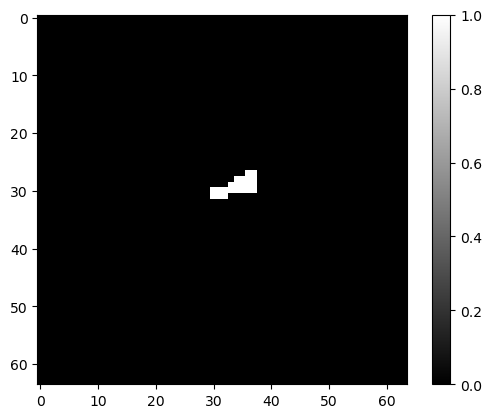

In [77]:
np.unique(trues)
plt.imshow(trues_copy[21], cmap='gray')  # or cmap='gray' if you want grayscale
plt.colorbar()  # optional, shows the scale
plt.show()

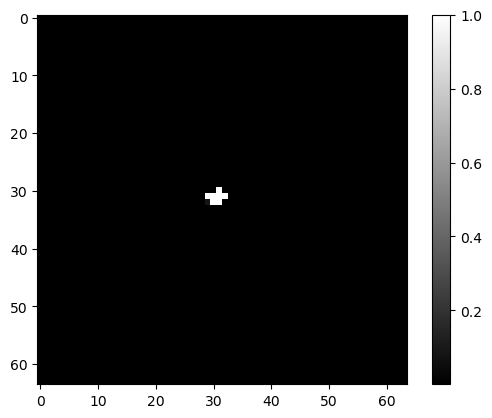

In [79]:
plt.imshow(preds_copy[21], cmap='gray')  # or cmap='gray' if you want grayscale
plt.colorbar()  # optional, shows the scale
plt.show()

In [75]:
(preds_copy > 0.5).astype(np.uint8).sum()

27298

In [76]:
trues.sum()

59852